<a href="https://colab.research.google.com/github/ubermenchh/jax-sandbox/blob/main/JAX_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax import jit, grad, vmap, pmap, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np

from typing import List

In [2]:
seed = 69

In [3]:
def mlp_init(layer_widths: List, parent_key: jax.Array, scale: float=0.01) -> List:
    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths) - 1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
            scale * jax.random.normal(weight_key, shape=(out_width, in_width)),
            scale * jax.random.normal(bias_key, shape=(out_width,))
        ])

    return params

In [4]:
key = jax.random.PRNGKey(seed)
mlp_params = mlp_init([784, 512, 256, 10], key)
print(jax.tree.map(lambda x: x.shape, mlp_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [5]:
def mlp_predict(params: List, x: np.ndarray) -> jax.Array:
    hidden_layers = params[:-1]

    act = x
    for w, b in hidden_layers:
        act = jax.nn.relu(jnp.dot(w, act) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, act) + b_last

    return logits - logsumexp(logits)

In [6]:
img_flat = np.random.randn(np.prod((28, 28)))
print(img_flat.shape)

(784,)


In [7]:
pred = mlp_predict(mlp_params, img_flat)
print(pred)

[-2.2955525 -2.2991154 -2.3055577 -2.2913444 -2.3170183 -2.2944772
 -2.296421  -2.318961  -2.2915165 -2.3164313]


In [8]:
batched_mlp_predict = vmap(mlp_predict, in_axes=(None, 0))

In [9]:
imgs_flat = np.random.randn(16, np.prod((28, 28)))
print(imgs_flat.shape)

(16, 784)


In [10]:
preds = batched_mlp_predict(mlp_params, imgs_flat)
print(preds.shape)

(16, 10)


In [11]:
def custom_transform(x: np.ndarray) -> np.ndarray:
    return np.ravel(np.array(x, dtype=np.float32))

In [12]:
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

In [13]:
batch_size = 128
train_dataset = MNIST(root="train_data", train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root="valid_data", train=False, download=True, transform=custom_transform)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]


Extracting train_data/MNIST/raw/train-images-idx3-ubyte.gz to train_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting train_data/MNIST/raw/train-labels-idx1-ubyte.gz to train_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting train_data/MNIST/raw/t10k-images-idx3-ubyte.gz to train_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.30MB/s]


Extracting train_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]


Extracting valid_data/MNIST/raw/train-images-idx3-ubyte.gz to valid_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 64.0kB/s]


Extracting valid_data/MNIST/raw/train-labels-idx1-ubyte.gz to valid_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting valid_data/MNIST/raw/t10k-images-idx3-ubyte.gz to valid_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.20MB/s]

Extracting valid_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to valid_data/MNIST/raw



In [14]:
batch_data = next(iter(train_dataloader))
imgs = batch_data[0]
labels = batch_data[1]
print(imgs.shape, imgs[0].dtype, labels.shape, labels[0].dtype)

(128, 784) float32 (128,) int64


In [15]:
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_labels = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_labels = jnp.array(test_dataset.targets)

In [16]:
num_epochs = 5

def loss_fn(params, imgs, gt_labels):
    preds = batched_mlp_predict(params, imgs)
    return -jnp.mean(preds * gt_labels)

In [17]:
def accuracy(params, dataset_imgs, dataset_labels):
    pred_classes = jnp.argmax(batched_mlp_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_labels == pred_classes)

In [18]:
@jit
def update(params, imgs, gt_labels, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_labels)

    return loss, jax.tree.map(lambda p, g: p - lr * g, params, grads)

In [19]:
mlp_params = mlp_init([np.prod((28, 28)), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):
    for cnt, (imgs, labels) in enumerate(train_dataloader):
        gt_labels = jax.nn.one_hot(labels, len(MNIST.classes))
        loss, mlp_params = update(mlp_params, imgs, gt_labels)

        if cnt % 50 == 0:
            print(loss)

    print(f"Epoch {epoch}, train_acc = {accuracy(mlp_params, train_images, train_labels)}, test_acc = {accuracy(mlp_params, test_images, test_labels)}")

0.23481856
0.10319078
0.063640505
0.046268925
0.034167845
0.043269362
0.043909293
0.029232448
0.03529191
0.02399239
Epoch 0, train_acc = 0.9135000109672546, test_acc = 0.9175999760627747
0.024508463
0.019911421
0.042556442
0.02895428
0.033896115
0.025443822
0.026979063
0.019834658
0.02178892
0.019899799
Epoch 1, train_acc = 0.9335833191871643, test_acc = 0.9333999752998352
0.03427101
0.023799822
0.023770044
0.01940826
0.027531857
0.020550868
0.035095196
0.017309645
0.016257843
0.013646779
Epoch 2, train_acc = 0.9455666542053223, test_acc = 0.9440000057220459
0.011687232
0.017992595
0.025748422
0.012829256
0.0129314205
0.0170866
0.01944495
0.030684775
0.023614053
0.023939809
Epoch 3, train_acc = 0.9529833197593689, test_acc = 0.9479999542236328
0.016063685
0.01219356
0.015527229
0.009730904
0.025672588
0.019194448
0.008446378
0.023193927
0.01647515
0.019153625
Epoch 4, train_acc = 0.9600833654403687, test_acc = 0.9565999507904053


In [20]:
imgs, labels = next(iter(test_dataloader))
img = imgs[69].reshape((28, 28))
gt_label = labels[69]
print(img.shape)

(28, 28)


In [21]:
import matplotlib.pyplot as plt

Pred: 0
Label: 0


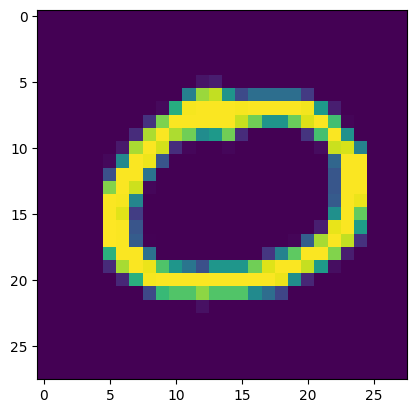

In [22]:
pred = jnp.argmax(mlp_predict(mlp_params, np.ravel(img)))
print("Pred:", pred)
print("Label:", gt_label)

plt.imshow(img); plt.show()